In [1]:
import sys

parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride

import pickle
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import matplotlib.pyplot as plt

from module.lino_module.preprocess import mode_of_freq, src_tgt_split

from typing import Tuple, Optional, Union
from numpy import ndarray
from pandas import DataFrame, Series, DatetimeIndex, Timestamp
from torch import Tensor
from torch.utils.data import DataLoader

/Users/lino/opt/anaconda3/envs/for_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 再帰的推論による推移

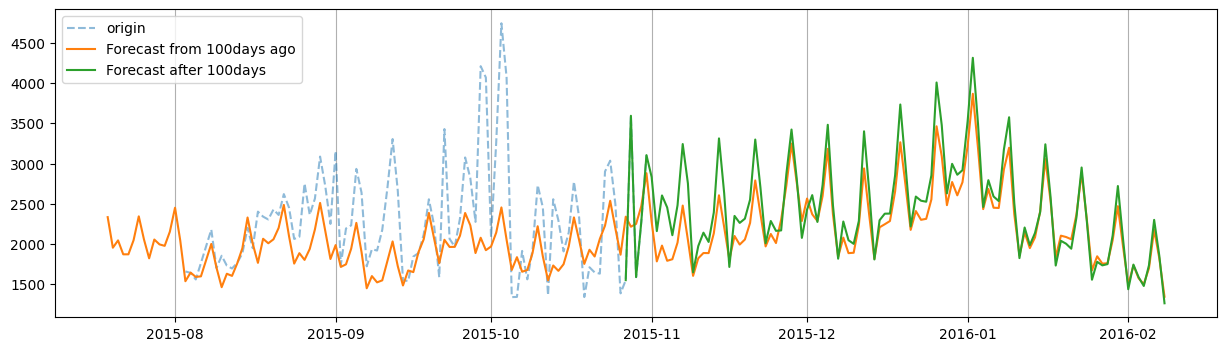

In [18]:
# from module.lino_module.inference import RecurrentInference

# モデルの呼び出し
predict_name = 'epochs(100)seq(14)_d_model(16)_dilation(2)_src_tgt_seq((9, 9))_step_num(5)_daily(True)_weekly(True)_weekly_num(True)_monthly(True)_scaler(StandardScaler)_'
file_path = './models_wm/' + predict_name + '.pkl'
with open(file_path, 'rb') as f:
    kw = pickle.load(f)

# キーワド引数の選定
ds = kw.pop('data')
scaler = kw.pop('scaler')
step_num = kw['step_num']
# 再帰推論回数の設定
freq = 20
# 未来の推論
self = RecurrentInference(**kw)
self(ds, scaler)
pred = self.predict(freq)

# 過去の推論
data = ds[:-freq * kw['step_num']]
self2 = RecurrentInference(**kw)
self2(data, scaler)
from_freq = self2.predict(freq*2)

# 描写と保存
img_path = '../Lino_notebook/img_infe_shifted/'
plt.figure(figsize=(15, 4))
plt.plot(ds[-90:], label='origin', alpha=0.5, linestyle='dashed')
plt.plot(from_freq, label=f'Forecast from {freq * step_num}days ago')
plt.plot(pred, label=f'Forecast after {freq * step_num}days')
plt.grid(axis='x')
plt.legend()
plt.savefig(img_path + predict_name + f'freq({freq}).png')
plt.show()

## 長期間における再帰的推論

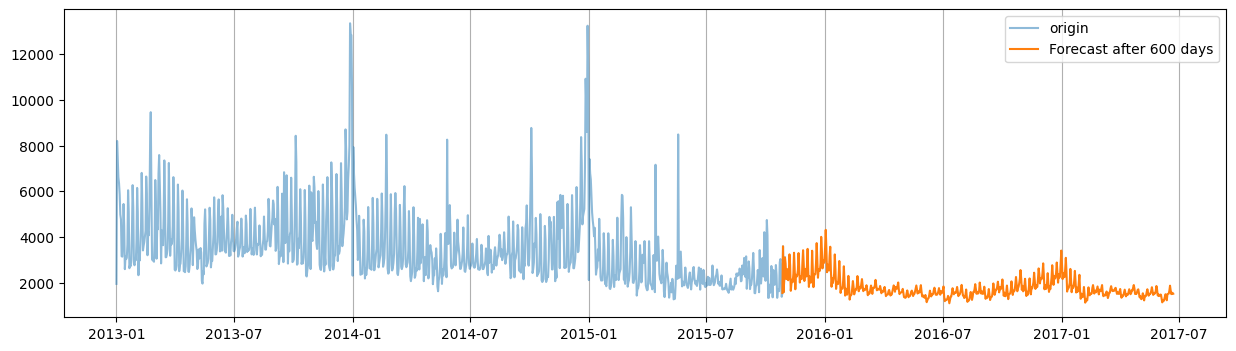

In [21]:
# 再帰推論回数の設定
freq = 120
# 未来の推論
self = RecurrentInference(**kw)
self(ds, scaler)
pred = self.predict(freq)
title = f'Forecast after {freq * step_num} days'
# 描写と保存
img_path = '../Lino_notebook/img_inference/'
plt.figure(figsize=(15, 4))
plt.plot(ds, label='origin', alpha=0.5)
plt.plot(pred, label=title)
plt.grid(axis='x')
plt.legend()
plt.savefig(img_path + predict_name + f'freq({freq}).png')
plt.show()

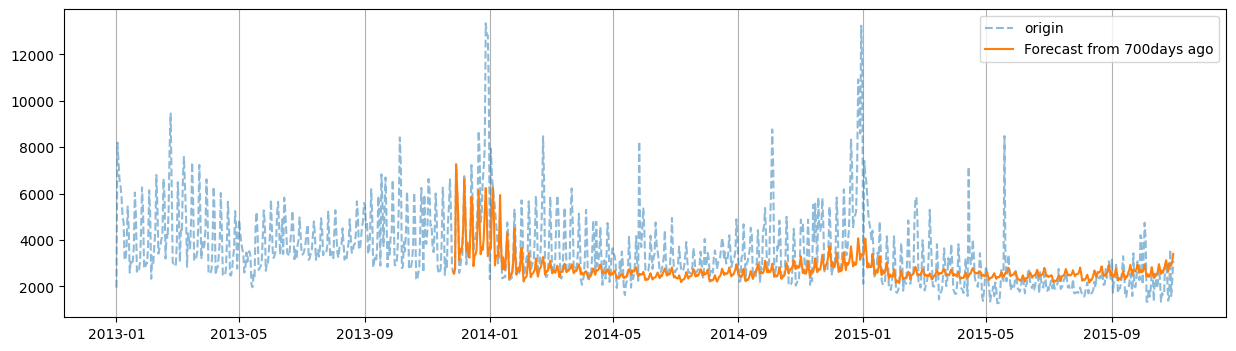

In [22]:
# 再帰推論回数の設定
freq = 140
data = ds[:-freq * kw['step_num']]
self2 = RecurrentInference(**kw)
self2(data, scaler)
from_freq = self2.predict(freq)

# 描写と保存
img_path = '../Lino_notebook/img_infe_shifted/'
plt.figure(figsize=(15, 4))
plt.plot(ds, label='origin', alpha=0.5, linestyle='dashed')
plt.plot(from_freq, label=f'Forecast from {freq * step_num}days ago')
plt.grid(axis='x')
plt.legend()
plt.savefig(img_path + predict_name + f'freq({freq}).png')
plt.show()

### 以下は推論用に作成したクラス

## Recurrent Inference Class

In [1]:
class RecurrentInference():
    """再起的に推論を行うクラス"""
    def __init__(self,
                 model,
                 seq,
                 d_model,
                 dilation,
                 src_tgt_seq,
                 step_num,
                 daily,
                 weekly,
                 weekly_num,
                 monthly):
        """ Initializer
        引数:
            model: 訓練済みモデル
            seq: 訓練条件時の seq
            d_model: 訓練条件時の d_model
            dilation: 訓練条件時の dilation
            src_tgt_seq: 訓練条件時の src_tgt_seq,
            weekly: 訓練条件時の曜日情報の有無
            monthly: 訓練条件時の月情報の有無
        """
        self.model: object = model
        self.seq: int = seq
        self.d_model: int = d_model
        self.dilation: int = dilation
        self.src_tgt_seq: Tuple[int] = src_tgt_seq
        self.step_num: int = step_num
        self.daily: bool = daily
        self.weekly: bool = weekly
        self.weekly_num: bool = weekly_num
        self.monthly: bool = monthly

        self.origin: Optional[Series] = None
        self.df: Optional[DataFrame] = None
        self.inferenced: Optional[Series] = None
        self.embedded: ndarray = None
        self.latest_index: Timestamp = None
        self.latest_data: float = None
        self.scaler: Optional[object] = None

    def __call__(self, ds: Series, scaler: Union[StandardScaler, MinMaxScaler]):
        """入力データを登録
        引数:
            ds: 訓練データセット作成時に使用したシリーズ
            scaler: 訓練時に使用したスケーラー
        """
        self.origin = ds.copy()
        reshaped = ds.values.reshape(-1, 1)
        self.scaler = scaler().fit(reshaped)
        scaled_ds = self.scaler.transform(reshaped).reshape(-1)

        # 入力データから推論に持ちるデータフレームを生成
        self.df = pd.DataFrame(scaled_ds,
                               columns=['data'],
                               index=ds.index.tolist())
        # 推論結果を書くのするデータフレームを生成
        self.latest_index = ds.index[-self.step_num:]
        self.latest_data = ds[-self.step_num:]
        self.inferenced = pd.Series(self.latest_data, index=self.latest_index)

        if self.daily:
            self.df['daily'] = ds.index.day / 31
        if self.weekly:
            self.df['weekly'] = ds.index.weekday / 6
        if self.weekly_num:
            scaled_calendar = (ds.index.isocalendar().week - 1) / 44
            self.df['weekly_num'] = scaled_calendar.values
        if self.monthly:
            self.df['monthly'] = (ds.index.month - 1) / 11

    def predict(self, freq):
        """推論用関数
        引数:
            freq: 再帰推論回数
        """
        for _ in range(freq):
            self.embedded = self.tde(self.df,
                                     self.seq,
                                     self.d_model,
                                     self.dilation)
            src, tgt = src_tgt_split(self.embedded, *self.src_tgt_seq)
            output = self.inference(self.model, src, tgt).reshape(-1)
            scaled = output[-self.step_num:]
            inversed = self.scaler.inverse_transform(scaled.reshape(-1, 1)).reshape(-1)

            # 推論の追加
            self.latest_index += datetime.timedelta(self.step_num)
            inferenced = pd.Series(inversed, index=self.latest_index)
            self.inferenced = pd.concat((self.inferenced, inferenced))

            # datasetの更新
            latest_data = {'data': scaled}
            if self.daily:
                scaled_daily = self.latest_index.day / 31
                latest_data['daily'] = scaled_daily
            if self.weekly:
                scaled_weekday = self.latest_index.weekday / 6
                latest_data['weekly'] = scaled_weekday
            if self.weekly_num:
                scaled_weekly_num = (self.latest_index.isocalendar().week - 1) / 44
                latest_data['weekly_num'] = scaled_weekly_num
            if self.monthly:
                scaled_month = (self.latest_index.month - 1) / 11
                latest_data['monthly'] = scaled_month
            latest = pd.DataFrame(latest_data, index=self.latest_index)
            self.df = pd.concat((self.df, latest))
        return self.inferenced

    @classmethod
    def tde(self,
            df: DataFrame,
            seq: int,
            d_model: int,
            dilation: int
            ) -> ndarray:
        """Time delay Embedding
           入力データ末端のseq分からTDEデータを作成
        引数:
            df: [data, weekly, monthly]のカラムと Timestamp インデックスを持ったデータフレーム
            seq: 訓練条件時の seq
            d_model: 訓練条件時の d_model
            dilation: 訓練条件時の dilation
        """
        embeded = []
        for column in df.columns:
            trg = getattr(df, column)
            tded = self.tde_for_inference(trg, seq, d_model, dilation)
            embeded.append(tded.tolist())
        embeded = np.array(embeded).reshape(d_model*len(df.columns), -1)
        return embeded

    @classmethod
    def inference(self, model: object, src: Tensor, tgt: Tensor) -> ndarray:
        """推論関数
        """
        src = torch.from_numpy(src.astype(np.float32)).unsqueeze(0)
        tgt = torch.from_numpy(tgt.astype(np.float32)).unsqueeze(0)
        model.eval()
        output = model(src, tgt).detach().numpy()
        return output

    @classmethod
    def tde_for_inference(self,
                          ds: Series,
                          seq: int,
                          d_model: int,
                          dilation: int
                          ) -> ndarray:
        for_array = []
        for i in range(d_model):
            if i != 0:
                for_array.append(ds[-seq - i*(dilation + 1): -i*(dilation + 1)])
            else:
                for_array.append(ds[-seq:])
        time_delay_embedded = np.array([j for j in reversed(for_array)])
        return time_delay_embedded


NameError: name 'Series' is not defined